### Use Keras to vectorize sentence 

#### load data 

https://archive-beta.ics.uci.edu/ml/datasets/331

In [1]:
import pandas as pd

filepath_dict = {'yelp':   'sentiment_data/yelp_labelled.txt',
                 'amazon': 'sentiment_data/amazon_cells_labelled.txt',
                 'imdb':   'sentiment_data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

In [2]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


#### split data into training and testing 

In [3]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [4]:

## previous notebook 

# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# vectorizer.fit(sentences_train)
# X_train = vectorizer.transform(sentences_train)
# X_test  = vectorizer.transform(sentences_test)
# X_train

<!-- You can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 20-40 epochs in this training. -->

In [5]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

Of all the dishes, the salmon was the best, but all were great.
[11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]


In [7]:
len(X_train[2])  # 3rd review

13

In [8]:
sentences_train[1]

'Sorry, I will not be getting food from here anytime soon :('

In [9]:
len(X_train[1]) # 2nd review 

11

###### observe that 
1) the length of the 2nd review is different from that of the 3rd review 
2) in the previous case, each word is represented by either 0 or 1, but here, each word is represented by a number 

In [6]:
vocab_size

1747

In [10]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 43
happy: 320
sad: 450


Note: Pay close attention to the difference between this technique and the X_train that was produced by scikit-learn’s CountVectorizer.

With CountVectorizer, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary tokenizer.word_index.

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number. In the following code, you can see how to pad sequences with Keras:

In [17]:
#### We want the represent of each sentence have the exact same length. 
#### use Padding from keras 

In [18]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100  # for each sentence, the length of the vector = 100 

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



In [14]:
len(X_train[2])

100

In [38]:
print(X_train[2, :])
print(sentences_train[2])

[ 11  43   1 171   1 283   3   1  47  26  43  24  22   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Of all the dishes, the salmon was the best, but all were great.


### Keras Embedding Layer
Notice that, at this point, our data is still hardcoded. We have not told Keras to learn a new embedding space through successive tasks. Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:

input_dim: the size of the vocabulary
output_dim: the size of the dense vector
input_length: the length of the sequence
With the Embedding layer we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a Dense layer. In order to do this you have to add a Flatten layer in between that prepares the sequential input for the Dense layer:

In [20]:
# previous case which has 2 Dense layers (hidden layers)

# model = Sequential()
# model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()

############## add new commands ##################
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

model.add(layers.Flatten())
##################################################


model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           87350     
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                50010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 137,371
Trainable params: 137,371
Non-trainable params: 0
_________________________________________________________________


You can now see that we have 87350 new parameters to train. This number comes from vocab_size times the embedding_dim. These weights of the embedding layer are initialized with random weights and are then adjusted through backpropagation during training. This model takes the words as they come in the order of the sentences as input vectors. You can train it with the following:

In [29]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.8120


In [31]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

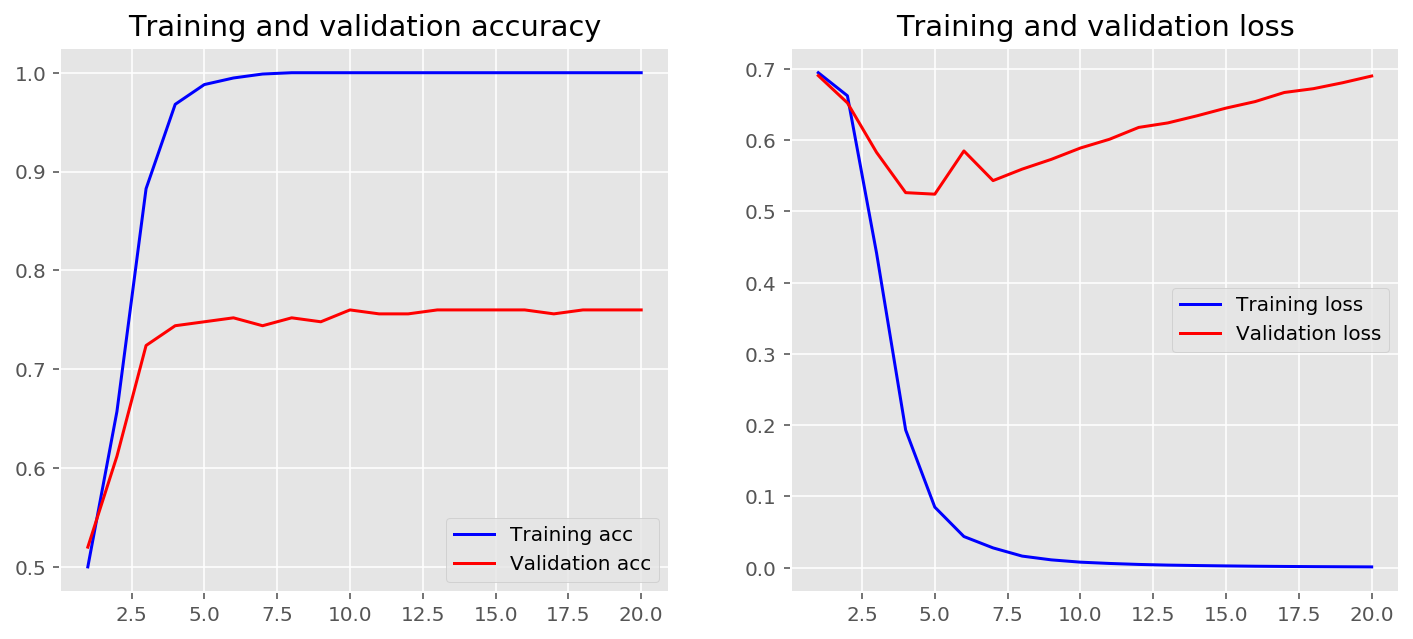

In [25]:
plot_history(history)

In [26]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()


model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

#### additional command from previous one 
model.add(layers.GlobalMaxPool1D())
##################################

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.8040


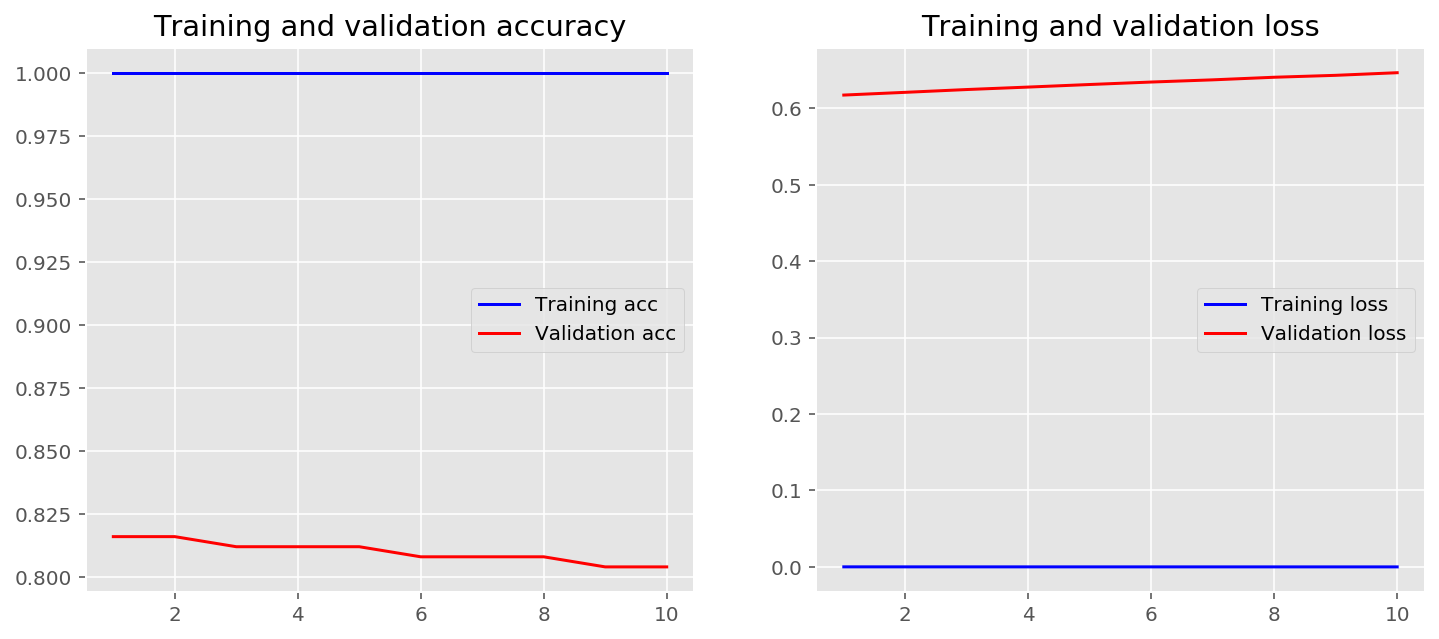

In [35]:
plot_history(history)

#### different methods of word-embedding

https://nlp.stanford.edu/projects/glove/

https://code.google.com/archive/p/word2vec/

https://radimrehurek.com/gensim/models/word2vec.html